__R-Model__ is the model that takes `r-neighborhood availability` into consideration of future movement decision.

This version makes `repulsiveProbability` a choice that takes the distance between the focal agent and a cell whose availability can be perceived by the focal agent.

09-04-2017

<hr>

In [1]:
import warnings
from itertools import product

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cityblock

In [3]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import BaseScheduler

In [4]:
from mesa.datacollection import DataCollector

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
def countAgentsOnBoard(model):
    '''Count the # of agents on a board'''
    return sum([not model.grid.is_cell_empty(cell[1:]) \
                for cell in model.grid.coord_iter()])

In [7]:
def repulsiveProbability(d, choice='inverse'):
    if choice.lower() == 'inverse':
        return inverseProbability(d)
    elif choice.lower() == 'exp':
        return expProbability(d)
    else:
        raise Exception('Please use either `inverse` or `exp` for decaying probability.')

In [8]:
def inverseProbability(d):
    return 1./((d+1)**2.2)

In [20]:
def expProbability(d):
    return 1/(1.165*np.exp(d))

<hr>

In [21]:
class MyActivation(BaseScheduler):
    ''' A customized activation scheduler to move agents simultaneously and break ties randomly. '''

    def break_ties(self):
        ''' Break ties randomly'''
        for agent in self.agents[:]:
            if agent.exitday is None:
                agent.find_newPos()
            
        agent_pos_df = pd.DataFrame([(agent, agent.newPos) for agent in self.agents[:] if agent.exitday is None],
                                    columns=['agent', 'newPos'])
        for newPos, df in agent_pos_df.groupby('newPos'):
            ''' randomly select one agent to move the that `newPos`'''
            selected_agent = df.agent[np.random.choice(df.agent.index)]
            for agent in df.agent:
                if agent is selected_agent:
                    continue
                ## agents not selected will stay put
                ## by setting `newPos` to `None`.
                agent.newPos = None
            print(newPos, [item.unique_id for item in df.agent], selected_agent.unique_id, 
                  [(item.unique_id, item.pos, item.newPos) for item in df.agent if item != selected_agent])
    
    def check_availability(self):
        '''Check if agents' `newPos` are available'''
        for agent in self.agents[:]:
            if agent.newPos is None:
                continue
            ## for those who are going to move, check if their future `dest` is available
            newPos_content_list = agent.model.grid.get_cell_list_contents(agent.newPos)
            for newPos_content in newPos_content_list:
                if newPos_content.newPos is None:
                    ## if it cannot move, reset `newPos`
                    agent.newPos = None
                    break
            print(agent.unique_id, agent.pos, agent.newPos, 
                  [(a.unique_id, a.pos, a.newPos) for a in newPos_content_list])

    def check_avail_wrapper(self):
        '''Due to the problem of synchronization, repeat doing this until converges'''
        converge = False
        last_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
        while not converge:
            self.check_availability()
            this_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
            if np.array_equal(this_newPos_array, last_newPos_array):
                converge = True
            last_newPos_array = np.asarray([agent.newPos for agent in self.agents[:]])
            
    def step(self):
        self.break_ties()
        self.check_avail_wrapper()
        for agent in self.agents[:]:
            if agent.exitday is None:
                agent.step()

<hr>

#### Agent and model class

##### Agents now know `r-neighborhood availability`

In [22]:
class CheckerAgent(Agent):
    '''
        A checker on the board showing on the left-most column
        and trying to go to the right-most column.

        Attributes
        ----------
        aid : the index among all agents born at timestamp `tid`
        model: the board that an agent will be in
        dest: destination
        birthday: the timestamp when an agent shows up in the left-most column
        exitday: the timestamp when an agent arrives at its `dest`
        R : `r-neighborhood availability`
    '''
    def __init__(self, aid, model, dest, birthday):
        super().__init__(aid, model)
        self.dest = dest
        self.newPos = None
        self.birthday = birthday
        self.exitday = None
        self.R = self.model.R

    def find_newPos(self):
        print('--Find-newPos--')
        current_dist = cityblock(self.pos, self.dest)
        possible_move_positions = list()
        radius = np.max((1, self.R))
        for neighbor in self.model.grid.iter_neighborhood(pos=self.pos, 
                                                          moore=False,
                                                          radius=radius):
            ## distance between the neighbor and its destination
            _dist = cityblock(neighbor, self.dest)
            if _dist < current_dist:
                #possible_move_positions.append((neighbor, 
                #                                self.model.grid.is_cell_empty(neighbor)))
                possible_move_positions.append(neighbor)
                
        ## `possible_move_positions` contain further-away cells (dist > 1)
        ## `r_neighborhood` would be those more than 1-hop away from `self.pos`
        r_neighborhood = [cell for cell in possible_move_positions if cityblock(cell, self.pos) > 1]
        ## `possible_move_positions` updated as those distances == 1 with `self.pos`
        possible_move_positions = [cell for cell in possible_move_positions if cell not in r_neighborhood]
        ## if more than two possible directions, raise Exception
        if len(possible_move_positions) > 2:
            print(possible_move_positions, r_neighborhood)
            raise Exception('More than two possible `newPos`\'s')
        ## if no possible directions, raise Exception
        elif len(possible_move_positions) < 1:
            raise Exception('Should have been removed!')
        
        ## only 1 possible choice, choose it
        if len(possible_move_positions) < 2:
            self.newPos  = possible_move_positions[0]
            return
        
        ## if there are two
        newPosProbability = (np.ones(shape=(len(possible_move_positions),), dtype=float)/len(possible_move_positions)).tolist()
        ## with no knowledge of the neighborhood, randomly choose one with equal probability
        ## else, check neighborhood availability
        if self.R > 0:
            for index in np.arange(len(possible_move_positions)):
                newPos = possible_move_positions[:][index]
                
                ## `r-1` neighborhood 
                newPos_neighbor = [cell for cell in r_neighborhood if cityblock(cell, newPos) <= self.R-1] 
                newPos_neighbor += [newPos]
                
                ## not empty, decrease probability
                newPosProbability[index] -= sum([repulsiveProbability(cityblock(self.pos, cell), 
                                                                      self.model.repulsiveChoice) \
                                                 if not self.model.grid.is_cell_empty(cell) else 0 \
                                                 for cell in newPos_neighbor ])
        ## normalize probability 
        newPosProbability = np.asarray(newPosProbability)/float(np.sum(newPosProbability))
        print(self.unique_id, self.pos, possible_move_positions, newPosProbability)    
        self.newPos = possible_move_positions[np.random.choice(len(possible_move_positions), 
                                                               p=newPosProbability)]

        print('--Done-find-newPos--')
        
    def step(self):
        if self.newPos is not None:
            self.model.grid.move_agent(self, self.newPos)
        if self.pos == self.dest:
            ## upon arrival, remove itself from the grid
            self.model.grid.remove_agent(self)
            #self.model.schedule.remove(self)
            self.exitday = self.model.timestamp
            print('Agent %d exits at time %d'%(self.unique_id, self.exitday))

##### Board model modified

Add `DataCollector` to the model.

In [23]:
class CheckerBoardModel(Model):
    '''
        A checker board bearing the agents.
        Each time step, a constant of agents will be added to the left-most column if avaialble.

        Attributes
        ----------
        aid : the index among all agents born at timestamp `tid`
        numAgents : the number of agents generated at each timestamp
        boardSize : the width and height of the grid
        R : `R-neighborhood availability`
        schedule : the scheduler to use
        timestamp : the current timestamp (starts at 0)
    '''
    def __init__(self, numAgents, boardSize, R=0, repulsiveChoice='inverse', seed=None):
        super().__init__(seed)
        ## number of agents
        if numAgents > boardSize:
            warnings.warn("# of agents is larger than the board size! Use board size %d as the number of agents"%boardSize,
                           RuntimeWarning)
            numAgents = boardSize
        self.numAgents = np.min((numAgents, boardSize))
        self.R = R
        self.repulsiveChoice = repulsiveChoice
        ## Not toroidial: cannot go across the border.
        self.grid = MultiGrid(boardSize, boardSize, False)
        self.schedule = MyActivation(self)
        self.timestamp = 0
        #self.cellCoords = list(product(np.arange(self.grid.width), 
        #                                np.arange(self.grid.width)))
        self.datacollector = DataCollector(
                                           model_reporters={"agentsOnBoard": countAgentsOnBoard},
                                           agent_reporters={'birthday': lambda a: a.birthday,
                                                            'exitday': lambda a: a.exitday}
                                          )
        #print('Current timestamp %d'%self.timestamp)
        ## Create agents
        for i in np.arange(self.numAgents):
            a = CheckerAgent(aid=i+1,
                             model=self,
                             birthday = self.timestamp,
                             dest=(boardSize-1,
                                   np.random.choice(self.grid.width)))
            ## destinations are sampled on the right-most column
            self.schedule.add(a)
            ## place they on the left-most column
            while True:
                xi = np.random.choice(self.grid.width)
                if self.grid.is_cell_empty((0, xi)):
                    self.grid.place_agent(a, (0, xi))
                    a.newPos = (0, xi)
                    break
                else:
                    continue
            
    def generate_new_agents(self):
        '''Generate new agents to the board if avaialble, AFTER step function'''
        ## check left-most columns availability
        available_cells = [xi for xi in np.arange(self.grid.width) \
                           if self.grid.is_cell_empty((0, xi))]
        numNewAgents = np.min((len(available_cells), self.numAgents))
        ## if no available slots, do not generate new agents
        if numNewAgents < 1:
            return
        ## re-order the availabilities randomly
        random_indices = np.random.choice(range(len(available_cells)), 
                                          replace=False, 
                                          size=numNewAgents)
        available_cells = [available_cells[i] for i in random_indices]
                                                                        
        ## index of the emerging agents: current max + 1
        starting_idx = max([a.unique_id for a in self.schedule.agents[:]]) + 1
        ## randomly assign positions (for k agents, k is the min of board size and availability)
        for i in np.arange(len(available_cells)):
            a = CheckerAgent(aid=starting_idx+i,
                             model=self,
                             birthday=self.timestamp,
                             dest=(self.grid.width-1,
                                   np.random.choice(self.grid.width)))
            self.schedule.add(a)
            self.grid.place_agent(a, (0, available_cells[i]))
            
    def check_cell_content(self):
        '''Check if one cell contains more than one agent at one timestamp after `step` and `generate` is done.'''
        cell_agent_count = dict()
        for cell in self.grid.coord_iter():
            cell_agent_count[cell[1:]] = len(cell[0])
        violated_cells = [cell for cell in cell_agent_count 
                          if cell_agent_count[cell] > 1]
        if len(violated_cells) > 0:
            print(violated_cells)
            raise Exception('More than two agents on one cell')
                
        
    def step(self):
        '''Advance the model by one step.
        
            One step includes:
            1) Move existing nodes using scheduler
            2) Generate new agents
            3) increment timestamp
        '''
        self.datacollector.collect(self)
        self.schedule.step()
        self.generate_new_agents()
        self.timestamp += 1
        self.check_cell_content()
        print('Current timestamp %d'%self.timestamp)
        print('-----------------------------------')

#### Testing code

In [24]:
boardModel = CheckerBoardModel(2, 3, 2, 'exp', seed=np.random.randint(100))

##### Try to move the agents

In [25]:
for i in range(100):
    boardModel.step()

--Find-newPos--
1 (0, 2) [(0, 1), (1, 2)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
2 (0, 0) [(1, 0), (0, 1)] [ 0.56571813  0.43428187]
--Done-find-newPos--
(1, 0) [2] 2 []
(1, 2) [1] 1 []
1 (0, 2) (1, 2) []
2 (0, 0) (1, 0) []
Current timestamp 1
-----------------------------------
--Find-newPos--
1 (1, 2) [(1, 1), (2, 2)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
2 (1, 0) [(2, 0), (1, 1)] [ 0.56571813  0.43428187]
--Done-find-newPos--
--Find-newPos--
3 (0, 0) [(1, 0), (0, 1)] [ 0.32430543  0.67569457]
--Done-find-newPos--
--Find-newPos--
4 (0, 2) [(0, 1), (1, 2)] [ 0.67569457  0.32430543]
--Done-find-newPos--
(0, 1) [3] 3 []
(1, 1) [1] 1 []
(1, 2) [4] 4 []
(2, 0) [2] 2 []
1 (1, 2) (1, 1) []
2 (1, 0) (2, 0) []
3 (0, 0) (0, 1) []
4 (0, 2) (1, 2) [(1, (1, 2), (1, 1))]
Current timestamp 2
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
3 (0, 1) [(1, 1), (0, 2)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
4 (1, 2) [(1, 1), (2, 2)] [ 0.

17 None (2, 1) []
18 None (2, 1) []
19 None (2, 2) []
21 (1, 1) (2, 1) []
23 (1, 2) (2, 2) []
25 (0, 2) None [(26, (0, 1), None)]
15 None (2, 2) []
17 None (2, 1) []
18 None (2, 1) []
19 None (2, 2) []
21 (1, 1) (2, 1) []
23 (1, 2) (2, 2) []
Agent 21 exits at time 23
Current timestamp 24
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
24 (0, 0) [(1, 0), (0, 1)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
25 (0, 2) [(0, 1), (1, 2)] [ 0.32430543  0.67569457]
--Done-find-newPos--
--Find-newPos--
26 (0, 1) [(0, 0), (1, 1)] [ 0.26924479  0.73075521]
--Done-find-newPos--
(0, 1) [24] 24 []
(1, 1) [26] 26 []
(1, 2) [25] 25 []
(2, 0) [22] 22 []
(2, 1) [20, 23] 20 [(23, (2, 2), None)]
15 None None [(23, (2, 2), None)]
17 None (2, 1) []
18 None (2, 1) []
19 None None [(23, (2, 2), None)]
20 (2, 0) (2, 1) []
21 None (2, 1) []
22 (1, 0) (2, 0) [(20, (2, 0), (2, 1))]
24 (0, 0) (0, 1) [(26, (0, 1), (1, 1))]
25 (0, 2) (1, 2) []
26 (0, 1) (1, 1) 

32 (1, 2) None [(34, (2, 2), None)]
33 (0, 1) None [(27, (1, 1), None)]
35 (0, 0) None [(30, (1, 0), None)]
36 (0, 2) None [(32, (1, 2), None)]
26 (2, 1) (2, 0) [(29, (2, 0), (2, 1))]
29 (2, 0) (2, 1) [(26, (2, 1), (2, 0))]
Agent 26 exits at time 44
Current timestamp 45
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
30 (1, 0) [(2, 0), (1, 1)] [ 0.88019486  0.11980514]
--Done-find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
35 (0, 0) [(1, 0), (0, 1)] [ 0.73023579  0.26976421]
--Done-find-newPos--
--Find-newPos--
(1, 0) [35] 35 []
(1, 1) [33] 33 []
(1, 2) [36] 36 []
(2, 0) [30] 30 []
(2, 1) [27, 34] 34 [(27, (1, 1), None)]
(2, 2) [29, 32] 29 [(32, (1, 2), None)]
26 None (2, 0) []
29 (2, 1) (2, 2) [(34, (2, 2), (2, 1))]
30 (1, 0) (2, 0) []
33 (0, 1) None [(27, (1, 1), None)]
34 (2, 2) (2, 1) [(29, (2, 1), (2, 2))]
35 (0, 0) (1, 0) [(30, (1, 0), (2, 0))]
36 (0, 2) None [(32, (1, 2), None)]
26 None (2, 0) []
29 (2, 1) (2, 2) 

46 (0, 0) (1, 0) [(43, (1, 0), (2, 0))]
48 (1, 2) None [(47, (2, 2), None)]
49 (0, 1) (1, 1) [(51, (1, 1), (2, 1))]
51 (1, 1) None [(50, (2, 1), None)]
52 (0, 2) (0, 1) [(49, (0, 1), (1, 1))]
43 (1, 0) (2, 0) []
45 None (2, 0) []
46 (0, 0) (1, 0) [(43, (1, 0), (2, 0))]
49 (0, 1) None [(51, (1, 1), None)]
52 (0, 2) None [(49, (0, 1), None)]
43 (1, 0) (2, 0) []
45 None (2, 0) []
46 (0, 0) (1, 0) [(43, (1, 0), (2, 0))]
Current timestamp 61
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
48 (1, 2) [(1, 1), (2, 2)] [ 0.26976421  0.73023579]
--Done-find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
52 (0, 2) [(0, 1), (1, 2)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
(1, 0) [53] 53 []
(1, 1) [49] 49 []
(1, 2) [52] 52 []
(2, 0) [46] 46 []
(2, 1) [43, 47, 51] 51 [(43, (2, 0), None), (47, (2, 2), None)]
(2, 2) [48, 50] 50 [(48, (1, 2), None)]
45 None None [(43, (2, 0), None)]
46 (1, 0) None [(43, (2, 0), None)]

53 (0, 0) None [(46, (1, 0), None)]
49 (0, 1) None [(51, (1, 1), None)]
Current timestamp 81
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
48 (1, 2) [(1, 1), (2, 2)] [ 0.26976421  0.73023579]
--Done-find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
52 (0, 2) [(0, 1), (1, 2)] [ 0.5  0.5]
--Done-find-newPos--
--Find-newPos--
(0, 1) [52] 52 []
(1, 0) [53] 53 []
(1, 1) [48, 49] 48 [(49, (0, 1), None)]
(2, 0) [46] 46 []
(2, 1) [43, 47, 51] 51 [(43, (2, 0), None), (47, (2, 2), None)]
(2, 2) [50] 50 []
46 (1, 0) None [(43, (2, 0), None)]
48 (1, 2) (1, 1) [(51, (1, 1), (2, 1))]
50 (2, 1) None [(47, (2, 2), None)]
51 (1, 1) None [(50, (2, 1), None)]
52 (0, 2) None [(49, (0, 1), None)]
53 (0, 0) None [(46, (1, 0), None)]
48 (1, 2) None [(51, (1, 1), None)]
Current timestamp 82
-----------------------------------
--Find-newPos--
--Find-newPos--
--Find-newPos--
--Find-newPos--
48 (1, 2) [(1, 1), (2, 2)] [ 0.26976421 

##### Read data

###### Model data

In [26]:
model_data_df = boardModel.datacollector.get_model_vars_dataframe()
model_data_df.head()

agentsOnBoard
0              2
1              4
2              6
3              7
4              9

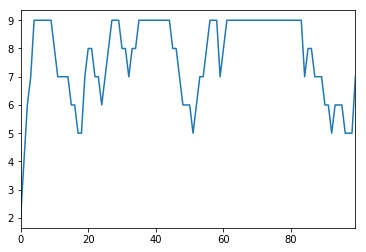

In [27]:
model_data_df.agentsOnBoard.plot()

###### Agent data

In [28]:
agent_data_df = boardModel.datacollector.get_agent_vars_dataframe()
agent_data_df.head()

birthday  exitday
Step AgentID                   
0    1               0      NaN
     2               0      NaN
1    1               0      NaN
     2               0      NaN
     3               0      NaN

In [29]:
agent_info_df = agent_data_df.query('Step==99')
agent_info_df.reset_index(level=0, drop=True, inplace=True)
agent_info_df.head()

birthday  exitday
AgentID                   
1               0     12.0
2               0      9.0
3               0     10.0
4               0     11.0
5               1     12.0

In [30]:
agent_info_df['duration'] = np.nan
exited_agents = agent_info_df.index[~agent_info_df.exitday.isnull()]
agent_info_df['duration'].loc[exited_agents] = agent_info_df['exitday'].loc[exited_agents] - \
                                               agent_info_df['birthday'].loc[exited_agents]
agent_info_df   

/Users/zhiyzuo/.virtualenvs/Use-Mesa/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zhiyzuo/.virtualenvs/Use-Mesa/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/zhiyzuo/.virtualenvs/Use-Mesa/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

birthday  exitday  duration
AgentID                             
1               0     12.0      12.0
2               0      9.0       9.0
3               0     10.0      10.0
4               0     11.0      11.0
5               1     12.0      11.0
6               1     14.0      13.0
7               2     14.0      12.0
8               3     16.0      13.0
9               3     13.0      10.0
10             11     16.0       5.0
11             12     15.0       3.0
12             12     15.0       3.0
13             13     17.0       4.0
14             14     16.0       2.0
15             15     21.0       6.0
16             15     17.0       2.0
17             16     22.0       6.0
18             16     21.0       5.0
19             17     22.0       5.0
20             17     29.0      12.0
21             18     23.0       5.0
22             18     24.0       6.0
23             19     30.0      11.0
24             21     32.0      11.0
25             22     31.0       9.0
26             22     44.0      22.0
27             24     47.0      23.0
28             24     31.0       7.0
29             25     45.0      20.0
30             26     47.0      21.0
...           ...      ...       ...
47             52     83.0      31.0
48             53     86.0      33.0
49             54     90.0      36.0
50             54     83.0      29.0
51             55     84.0      29.0
52             59     89.0      30.0
53             60     88.0      28.0
54             84     89.0       5.0
55             84     90.0       6.0
56             87     91.0       4.0
57             87     89.0       2.0
58             88     93.0       5.0
59             89     92.0       3.0
60             89     91.0       2.0
61             90     94.0       4.0
62             90     93.0       3.0
63             91     95.0       4.0
64             92     96.0       4.0
65             92     94.0       2.0
66             93     95.0       2.0
67             93     96.0       3.0
68             94     97.0       3.0
69             94     97.0       3.0
70             95      NaN       NaN
71             96      NaN       NaN
72             96      NaN       NaN
73             97      NaN       NaN
74             97      NaN       NaN
75             98      NaN       NaN
76             98      NaN       NaN

[76 rows x 3 columns]

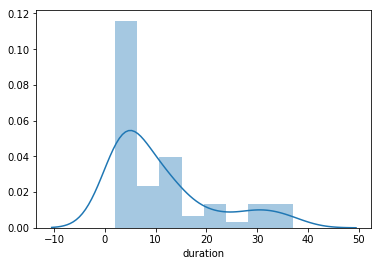

In [31]:
sns.distplot(agent_info_df.duration[~agent_info_df.duration.isnull()])

<hr>

Use visualization to test.

Seems like working.